# Exploration, dimensionality reduction and preparation of data from Crystallographic Open Database (COD) for input to machine learning models

## 1. Download and extract .cif files from COD .zip file

In [ ]:
#   # check the current directory to now 
#   os.getcwd()

#   # download COD database and extract .cif files into 'cifs' directory
#   !wget http://www.crystallography.net/archives/cod-cifs-mysql.zip .
#   %rm -rf mysql
#   !unzip cod-cifs-mysql.zip > /dev/null
#   !mkdir cifs
#   %cd cif/
#   !find . -name '*.cif' -exec mv {} ../cifs \;
#   %cd ..
#   %rm -rf cif
#   %rm cod-cifs-mysql.zip
#
#   # populate a .csv file with the .cif filenames
#   !touch cifnames.csv
#   %cd cifs
#   !ls > ../cifnames.csv
#   %cd ..

## 2. Check uniqueness of .cif files

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)

In [2]:
cifs = pd.read_csv('cifnames.csv', header=None)
cifs.rename(columns={0: 'filename'}, inplace=True)
cifs['filename'] = cifs['filename'].apply(lambda x: pd.NA if '.cif' not in x else x)

In [3]:
cifs

,filename
0,1000000.cif
1,1000002.cif
2,1000003.cif
3,1000004.cif
4,1000005.cif
...,...
495127,9017915.cif
495128,9017917.cif
495129,9017918.cif
495130,9017919.cif


In [5]:
cifs['filename'].nunique() == len(cifs)

True

The number of unique .cif filenames equals the length of the dataframe, so all the files are unique.

## 3. Create dataframe showing which .cif files contain which elements

This section extracts the number of times each element occurs in each .cif file. It does not count their relative proportions as per the chemical formulae; it just assigns a 1 for "yes, this .cif file contains hydrogen", or 0 for no, etc.

NOTE: The entire set of 500,000 or so .cif files takes about 5 hours to process when parallelised across 16 cores using the process_file() function. Approach with patience. (Or improve my code :) )

In [6]:
import os

elements = {1:"H",2:"He",3:"Li",4:"Be",5:"B",6:"C",7:"N",8:"O",9:"F",10:"Ne",
11:"Na",12:"Mg",13:"Al",14:"Si",15:"P",16:"S",17:"Cl",18:"Ar",19:"K",20:"Ca",
21:"Sc",22:"Ti",23:"V",24:"Cr",25:"Mn",26:"Fe",27:"Co",28:"Ni",29:"Cu",30:"Zn",
31:"Ga",32:"Ge",33:"As",34:"Se",35:"Br",36:"Kr",37:"Rb",38:"Sr",39:"Y",40:"Zr",
41:"Nb",42:"Mo",43:"Tc",44:"Ru",45:"Rh",46:"Pd",47:"Ag",48:"Cd",49:"In",50:"Sn",
51:"Sb",52:"Te",53:"I",54:"Xe",55:"Cs",56:"Ba",57:"La",58:"Ce",59:"Pr",60:"Nd",
61:"Pm",62:"Sm",63:"Eu",64:"Gd",65:"Tb",66:"Dy",67:"Ho",68:"Er",69:"Tm",70:"Yb",
71:"Lu",72:"Hf",73:"Ta",74:"W",75:"Re",76:"Os",77:"Ir",78:"Pt",79:"Au",80:"Hg",
81:"Tl",82:"Pb",83:"Bi",84:"Po",85:"At",86:"Rn",87:"Fr",88:"Ra",89:"Ac",90:"Th",
91:"Pa",92:"U",93:"Np",94:"Pu",95:"Am",96:"Cm",97:"Bk",98:"Cf",99:"Es",100:"Fm",
101:"Md",102:"No",103:"Lr",104:"Rf",105:"Db",106:"Sg",107:"Bh",108:"Hs",109:"Mt",
110:"Ds",111:"Rg",112:"Cn",113:"Nh",114:"Fl",115:"Mc",116:"Lv",117:"Ts",118:"Og",
}

directory = 'cifs' # this directory was created with !mkdir cifs above
filenames = os.listdir(directory)

In [ ]:
# dataframe with atomic numbers 0 to 118 as columns; .cif filenames as index
# df = pd.DataFrame(0, columns=elements.keys(), index=filenames)

In [ ]:
#   import os
#   import numpy as np
#   from ase.io import read
#   from multiprocessing import Pool, cpu_count
#   from functools import partial
#   import pandas as pd
#   
#   pd.set_option('display.max_columns', None)
#   
#   def process_file(filename, directory):
#       """
#       Reads a .cif file in a specified directory and returns a tuple with
#       filename and a dict of length 118 (the maximum atomic number considered)
#       where the keys are the atomic number and the values are 1 or 0 depending
#       on whether the elements with that atomic number occur in the file,
#       irrespective of quantity or chemical formula.
#   
#       e.g. for a .cif containing only H and Li, the return value is:
#       
#       ('my_LiH_cif_file.cif', {1:1, 2:0, 3:1, 4:0, 5:0, 6:0, ... , 118:0})
#       """
#       
#       vec = np.zeros(len(elements))
#       try:
#           atoms = read(f'{directory}/{filename}')
#           atomic_numbers = list(set(atoms.get_atomic_numbers()))
#           row = dict.fromkeys(range(1, 119), 0)
#           for num in atomic_numbers:
#               row[num] = 1
#           return (filename, row)
#       except Exception as e:
#           os.remove(f'{directory}/{filename}')        
#           return (filename, None)
#           print(f'File {filename} failed: {e}')
#   
#   # Define your directory
#   directory = 'cifs'
#   
#   # Use partial to create a new function with directory pre-filled
#   process_file_in_directory = partial(process_file, directory=directory)
#   
#   # create a multiprocessing pool
#   pool = Pool(cpu_count())
#   
#   # process files in parallel
#   results = pool.map(process_file_in_directory, filenames)
#   
#   # close the pool and wait for all processes to finish
#   pool.close()
#   pool.join()
#   
#   # filter out unsuccessful results and create dataframe with filenames as
#   # index and columns as atomic number
#   successful_results = [result for result in results if result[1] is not None]
#   indices = [result[0] for result in successful_results]
#   data = [result[1] for result in successful_results]
#   df = pd.DataFrame(data, index=indices)
#   
#   
#   df.to_csv('counts.csv')

In [50]:
df = pd.read_csv('counts.csv', index_col=0)
df = df.drop('0', axis=1) # I forgot to set index=False in the .to_csv() method above but didn't want to re-run it for 5 hours

In [8]:
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118
7202035.cif,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4318965.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2238511.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7121865.cif,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007483.cif,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007991.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2005370.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8102810.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7243130.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


This dataframe has the atomic number in the columns, and the .cif file name in the rows.

## 4. Data visualisation

### 4a. How many unique elements tend to be in each compound

Firstly, let's look at the distribution of how many elements are in each .cif file:

In [9]:
num_unique_elements_dist = df.sum(axis=1).value_counts().sort_index()
num_unique_elements_dist

1       2572
2      16618
3      57305
4     111000
5     145148
6     101334
7      44144
8      13452
9       3038
10       483
11        38
Name: count, dtype: int64

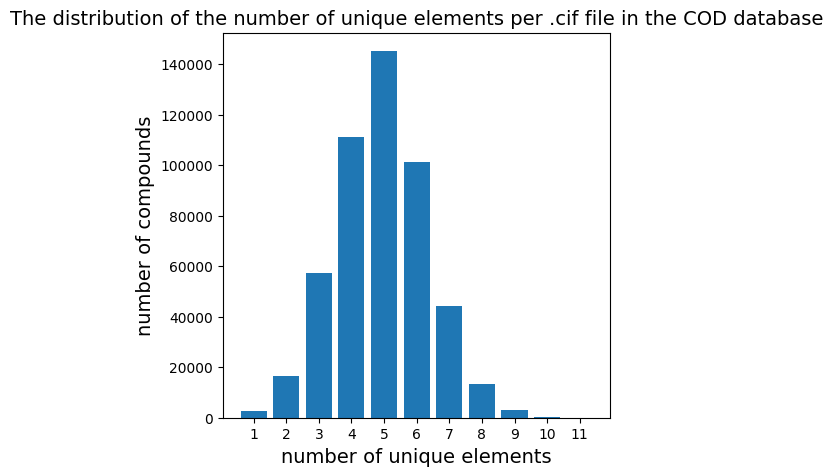

In [10]:
barchart0 = plt.figure(figsize=(5,5))
ax0 = barchart0.add_subplot(111)
ax0.bar(num_unique_elements_dist.index, num_unique_elements_dist.values)
ax0.set_title('The distribution of the number of unique elements per .cif file in the COD database', fontsize=14)
ax0.set_xlabel('number of unique elements', fontsize=14)
ax0.set_ylabel('number of compounds', fontsize=14)
ax0.set_xticks(np.arange(1,12,1))
ax0.tick_params(axis='both',labelsize=10)
plt.show()

### 4b. How often does each element turn up

Let's look at how often each element appears in the database:

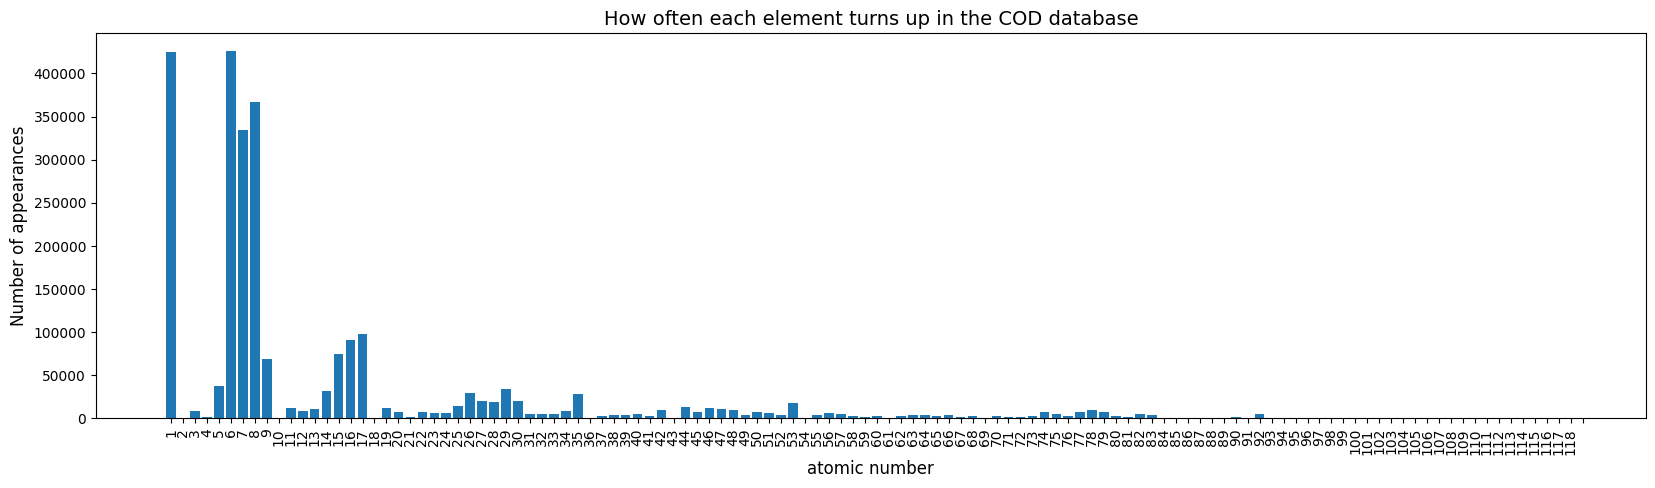

In [11]:
import matplotlib.pyplot as plt
import numpy as np

atomic_numbers = df.sum(axis=0).index
atomic_numbers_freq = df.sum(axis=0).values

# Plot the barchart 
barchart1 = plt.figure(figsize=(20,5))
ax1 = barchart1.add_subplot(111)
ax1.bar(atomic_numbers, atomic_numbers_freq)
ax1.set_title('How often each element turns up in the COD database', fontsize=14)
ax1.set_xlabel('atomic number', fontsize=12)
ax1.set_ylabel('Number of appearances', fontsize=12)
ax1.tick_params(axis='both', which='major',labelsize=10)
plt.xticks(np.arange(0,119,1), rotation='vertical')
plt.show()

So there's somewhere around 3 to 7 elements per .cif file, and most of them tend to involve the typical organic elements such as H, C, N, and O.

Since not much above Z=83 turns up, drop those columns, and save the updated dataframe. (Sorry, Uranium.)

In [51]:
df = df.drop([str(i) for i in range(84, 119)], axis=1)
atomic_numbers = [str(i) for i in range(1, 84)]
df.to_csv('counts-reduced.csv')

In [13]:
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83
7202035.cif,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4318965.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2238511.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7121865.cif,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007483.cif,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007991.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2005370.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8102810.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7243130.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 4c. How do the elements correlate with eachother: Brute force intuitive approach for elements 1 to 9 inclusive.

A straightforward function to pick out the filenames containing certain elements and excluding others is a useful way to build some intuition of where in the periodic table most of the elements are occurring in the database.

In [14]:
def get_cif_filenames(df, atomic_numbers, include_all=False, exclude_others=True):
    
    mask = df.columns.isin(atomic_numbers)
    notmask = ~mask
    
    if include_all == True and exclude_others == True:    
        filenames_mask = (df.loc[:, mask].eq(1).all(axis=1)) & (df.loc[:, notmask].eq(0).all(axis=1))
        filenames = list(filenames_mask[filenames_mask].index)
        return filenames
    
    elif include_all == False and exclude_others == True:
        filenames_mask = (df.loc[:, mask].eq(1).any(axis=1)) & (df.loc[:, notmask].eq(0).all(axis=1))
        filenames = list(filenames_mask[filenames_mask].index)
        return filenames

    elif include_all == True and exclude_others == False:
        filenames_mask = (df.loc[:, mask].eq(1).all(axis=1))
        filenames = list(filenames_mask[filenames_mask].index)
        return filenames
    
    elif include_all == False and exclude_others == False:
        filenames_mask = (df.loc[:, mask].eq(1).any(axis=1))
        filenames = list(filenames_mask[filenames_mask].index)
        return filenames
    
    else:
        return None

    
def get_num_cif_files(df, atomic_numbers, include_all=False, exclude_others=True):
    
    return len(get_cif_filenames(df, atomic_numbers, include_all, exclude_others))

Since the atomic numbers 1 - 9 inclusive are generally fairly abundant in the database compared to the other elements, it's not too silly to use a brute force method to work out how many .cif files would be obtained by filtering by all possible subsets. (Doing this for all Z up to 100 or so would result in a combinatorial explosion; 9 choose 5 {the biggest combination} is 126 which is not large.)

In [15]:
import pandas as pd
import numpy as np
from itertools import chain, combinations
from multiprocessing import Pool

# Define the atomic_number_range
atomic_number_range = [str(Z) for Z in range(1, 10)]

# Create the subsets of atomic numbers
subsets = list(chain(*map(lambda x: combinations(atomic_number_range, x), range(2, len(atomic_number_range)+1))))

def process_subset(subset):

    # Create a dictionary with default value 0
    row = dict.fromkeys(atomic_number_range, 0)
    
    # Update the dictionary with the subset (set value to 1)
    for letter in subset:
        row[letter] = 1

    row['num_files'] = get_num_cif_files(df, subset, include_all=False, exclude_others=True)
    
    return row

# Create a multiprocessing Pool
with Pool() as p:
    rows = p.map(process_subset, subsets)

# Convert the list of dictionaries to a DataFrame
num_files_df = pd.DataFrame(rows, columns=['num_files'] + atomic_number_range)
num_files_df.sort_values('num_files', ascending=False)

,num_files,1,2,3,4,5,6,7,8,9
501,91894,1,1,1,1,1,1,1,1,1
499,91885,1,0,1,1,1,1,1,1,1
497,91695,1,1,1,0,1,1,1,1,1
482,91686,1,0,1,0,1,1,1,1,1
498,90411,1,1,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
0,62,1,1,0,0,0,0,0,0,0
9,51,0,1,0,1,0,0,0,0,0
14,50,0,1,0,0,0,0,0,0,1
10,48,0,1,0,0,1,0,0,0,0


While 90275 files that contain any combination of elements 1 to 9 inclusive sounds like a reasonable dataset, the sparsity of the input space is more sensibly measured by taking some quantity raised to the power of the number of elements:

In [16]:
num_files_df['total_num_elements'] = num_files_df[atomic_number_range].apply(lambda row: sum(row), axis=1)
num_files_df['sparsity'] = np.exp(num_files_df['total_num_elements']) / num_files_df['num_files']
num_files_df = num_files_df.sort_values('sparsity', ascending=True)
num_files_df

,num_files,1,2,3,4,5,6,7,8,9,total_num_elements,sparsity
172,76043,1,0,0,0,0,1,1,1,0,4,0.000718
59,19780,1,0,0,0,0,1,0,1,0,3,0.001015
315,84085,1,0,0,0,0,1,1,1,1,5,0.001765
311,79726,1,0,0,0,1,1,1,1,0,5,0.001862
297,77100,1,0,1,0,0,1,1,1,0,5,0.001925
...,...,...,...,...,...,...,...,...,...,...,...,...
485,641,0,1,1,1,1,1,1,0,1,7,1.710816
487,640,0,1,1,1,1,0,1,1,1,7,1.713489
500,1343,0,1,1,1,1,1,1,1,1,8,2.219626
460,487,1,1,1,1,1,0,1,0,1,7,2.251813


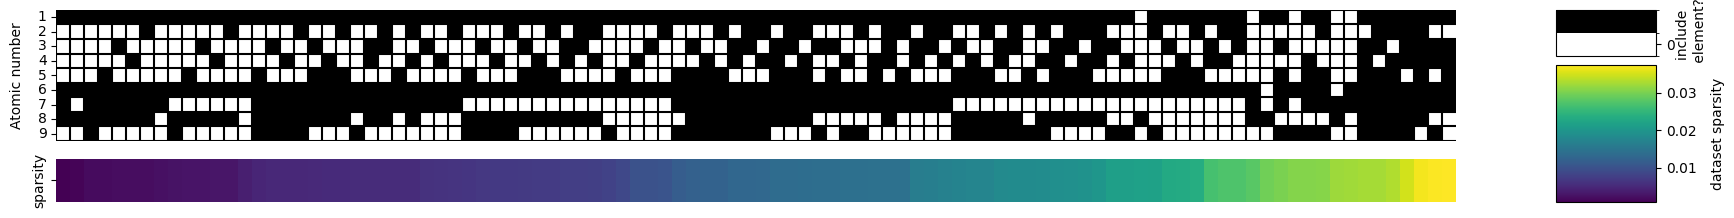

In [17]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

# Select subset of columns for binary and sparsity data
num_files_df_subset = num_files_df[:100]
binary_df = num_files_df_subset[['1', '2', '3', '4', '5', '6', '7', '8', '9']]  # replace with your binary column names
continuous_df = num_files_df_subset[['sparsity']]  # replace with your continuous column name

fig = plt.figure(figsize=(20, 2.5))

# Create a gridspec object for heatmaps
gs_heatmaps = gridspec.GridSpec(2, 1, height_ratios=[3, 1], width_ratios=[1], left=0.1, right=0.8, wspace=0.05)

# Binary heatmap
ax1 = plt.subplot(gs_heatmaps[0])
sns.heatmap(binary_df.T, cmap='binary', cbar=False, yticklabels=True, xticklabels=False, ax=ax1)
ax1.set_ylabel('Atomic number', rotation=90, labelpad=10)  # Add y-axis label
plt.setp(ax1.get_yticklabels(), rotation=0)  # Rotate y-tick labels

# Add gridlines
ax1xlimits = ax1.get_xlim()
ax1.hlines([i for i in range (0, len(atomic_number_range)+1)], ax1xlimits[0], ax1xlimits[1], color='black')
ax1ylimits = ax1.get_ylim()
ax1.vlines([i for i in range(0, len(binary_df))], ax1ylimits[0], ax1ylimits[1], color='black')

# Continuous heatmap
ax2 = plt.subplot(gs_heatmaps[1])
sns.heatmap(continuous_df.T, cmap='viridis', cbar=False, yticklabels=True, xticklabels=False, ax=ax2)

# Create a gridspec object for colorbars
gs_colorbars = gridspec.GridSpec(2, 1, height_ratios=[1, 3], left=0.85, right=0.9, hspace=0.1)

# Binary colorbar (1, 0)
ax3 = plt.subplot(gs_colorbars[0])
cmap = mcolors.ListedColormap(['white', 'black'])
bounds = [0, 0.5, 0.6]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
cb1 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
                   cax=ax3,
                   ticks=[0.25, 0.75],
                   orientation='vertical')
cb1.set_label('include \n element?', rotation=90, labelpad=1)
cb1.set_ticklabels(['0', '1'])

# Colorbar for sparsity data
ax4 = plt.subplot(gs_colorbars[1])
cbar = plt.colorbar(ax2.collections[0], cax=ax4, use_gridspec=True)
cbar.set_label('dataset sparsity', rotation=90, labelpad=10)

plt.show()

The least sparse subset of .cif files we could choose according to this analysis consists of those containing any combination of elements with atomic numbers 1,6,7, and 8 at the exclusion of all other elements, which is not too surprising.

### 4d. How do the elements correlate with eachother: correlation matrix approaches for elements 1 to 84

Let's plot the Pearson correlation matrix to see which elements co-occur: (remember we've not extracted chemical formulae, just 1 or 0 for whether each element turns up)

In [18]:
# Pearson correlation matrix
corr_matrix = df.corr(method='pearson')

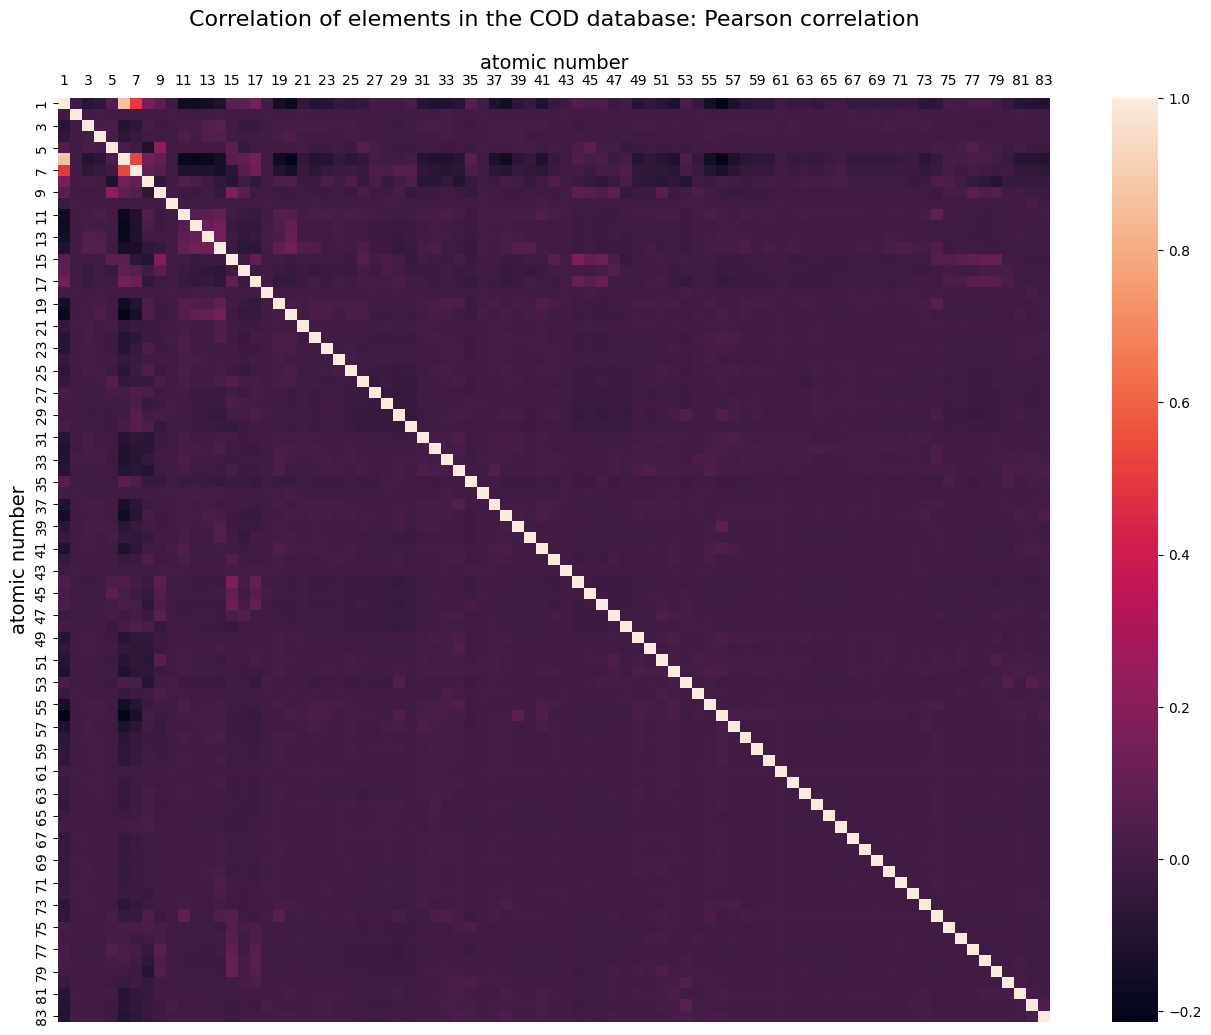

In [19]:
import seaborn as sns

heatmap = plt.figure(figsize=(16, 12))
ax5 = sns.heatmap(corr_matrix)
sns.set(font_scale=0.5)
ax5.set_ylabel('atomic number', fontsize=14)
ax5.set_xlabel('')  # Empty xlabel
ax5.xaxis.tick_top()  # x axis on top
ax5.xaxis.set_label_position('top')  # x axis label on top
ax5.set_xlabel('atomic number', fontsize=14)
ax5.set_title('Correlation of elements in the COD database: Pearson correlation', fontsize=16, pad=20)
ax5.tick_params(axis='x', which='both', bottom=False, top=False)  # remove x-axis ticks
plt.show()

This is actually a red flag because while there's strong correlation around the Carbon (Z=6) region, Oxygen (Z=8) does not appear very prominently.

Since the data is binary ("does this element appear in this .cif file; yes or no"), it's better to use metrics that are more suitable for associations in binary data, such as the Jaccard index or the Matthews correlation coefficient:

In [20]:
import pandas as pd
import numpy as np
from sklearn.metrics import matthews_corrcoef
from itertools import combinations
from concurrent.futures import ProcessPoolExecutor

def jaccard_similarity(column1, column2):
    intersection = np.logical_and(column1, column2)
    union = np.logical_or(column1, column2)
    similarity = intersection.sum() / float(union.sum())
    return similarity

def calculate_metrics(pair):
    col1, col2 = pair
    return {
        'pair': pair,
        'jaccard': jaccard_similarity(df[col1], df[col2]),
        'mcc': matthews_corrcoef(df[col1], df[col2]),
    }

# Jaccard index matrix
jaccard_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

# Matthews correlation coefficient matrix
mcc_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

# Compute pairwise metrics for each pair of columns
with ProcessPoolExecutor() as executor:
    results = list(executor.map(calculate_metrics, combinations(df.columns, 2)))

for result in results:
    col1, col2 = result['pair']
    jaccard_matrix.loc[col1, col2] = result['jaccard']
    mcc_matrix.loc[col1, col2] = result['mcc']

# Copy lower triangle to upper triangle to make the matrices symmetric
for df_ in [jaccard_matrix, mcc_matrix]:
    df_.update(df_.transpose())
    
np.fill_diagonal(jaccard_matrix.values, 1)
np.fill_diagonal(mcc_matrix.values, 1)

jaccard_matrix = jaccard_matrix.apply(pd.to_numeric)
mcc_matrix = mcc_matrix.apply(pd.to_numeric)

Let's plot the pairwise matrices showing the Jaccard index and Matthews correlation coefficient:

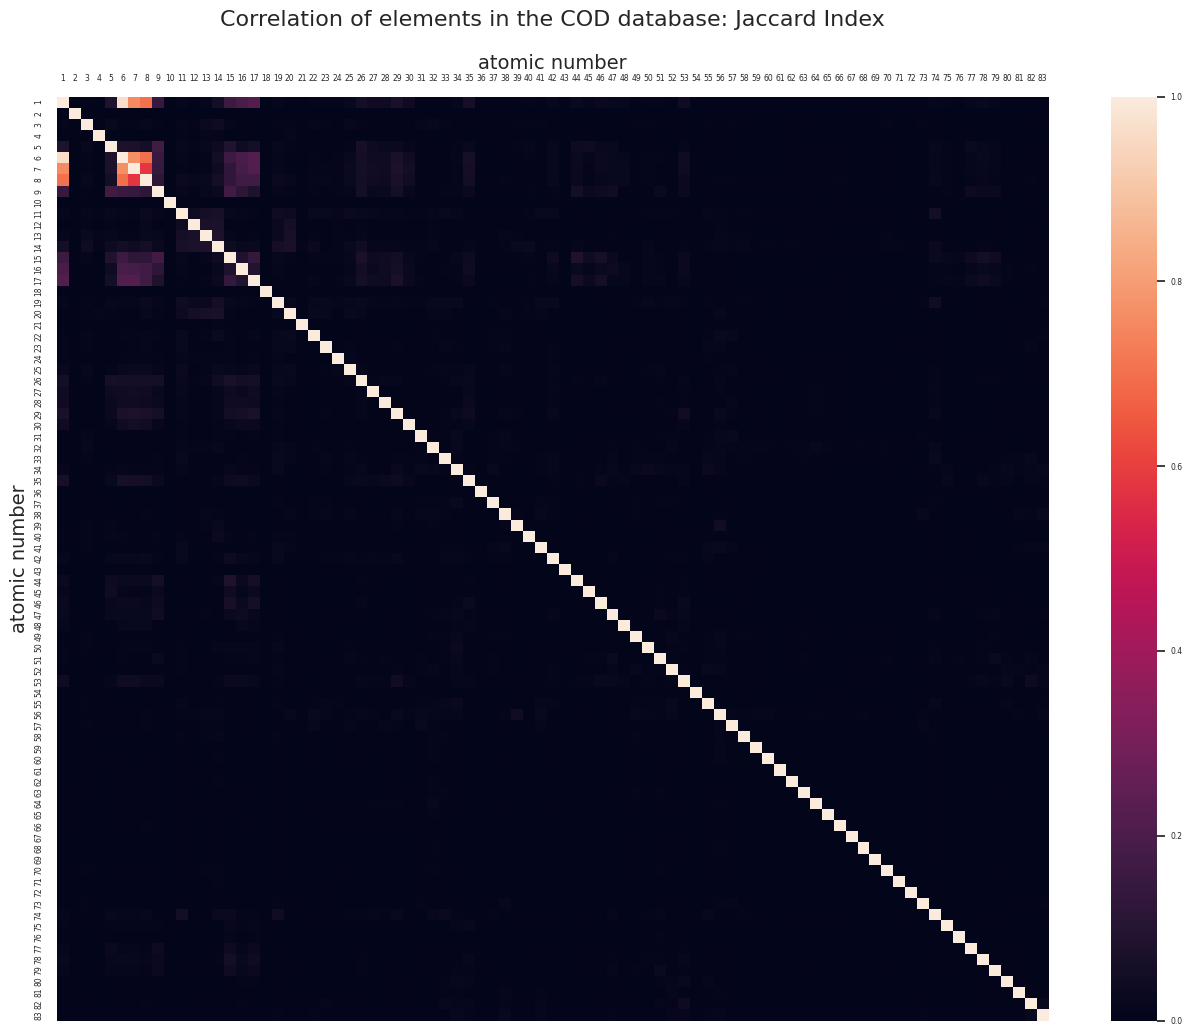

In [21]:
heatmap = plt.figure(figsize=(16, 12))
ax6 = sns.heatmap(jaccard_matrix)
sns.set(font_scale=0.5)
ax6.set_ylabel('atomic number', fontsize=14)
ax6.set_xlabel('')  # Empty xlabel
ax6.xaxis.tick_top()  # x axis on top
ax6.xaxis.set_label_position('top')  # x axis label on top
ax6.set_xlabel('atomic number', fontsize=14)
ax6.set_title('Correlation of elements in the COD database: Jaccard Index', fontsize=16, pad=20)
ax6.tick_params(axis='x', which='both', bottom=False, top=False)  # remove x-axis ticks
plt.show()

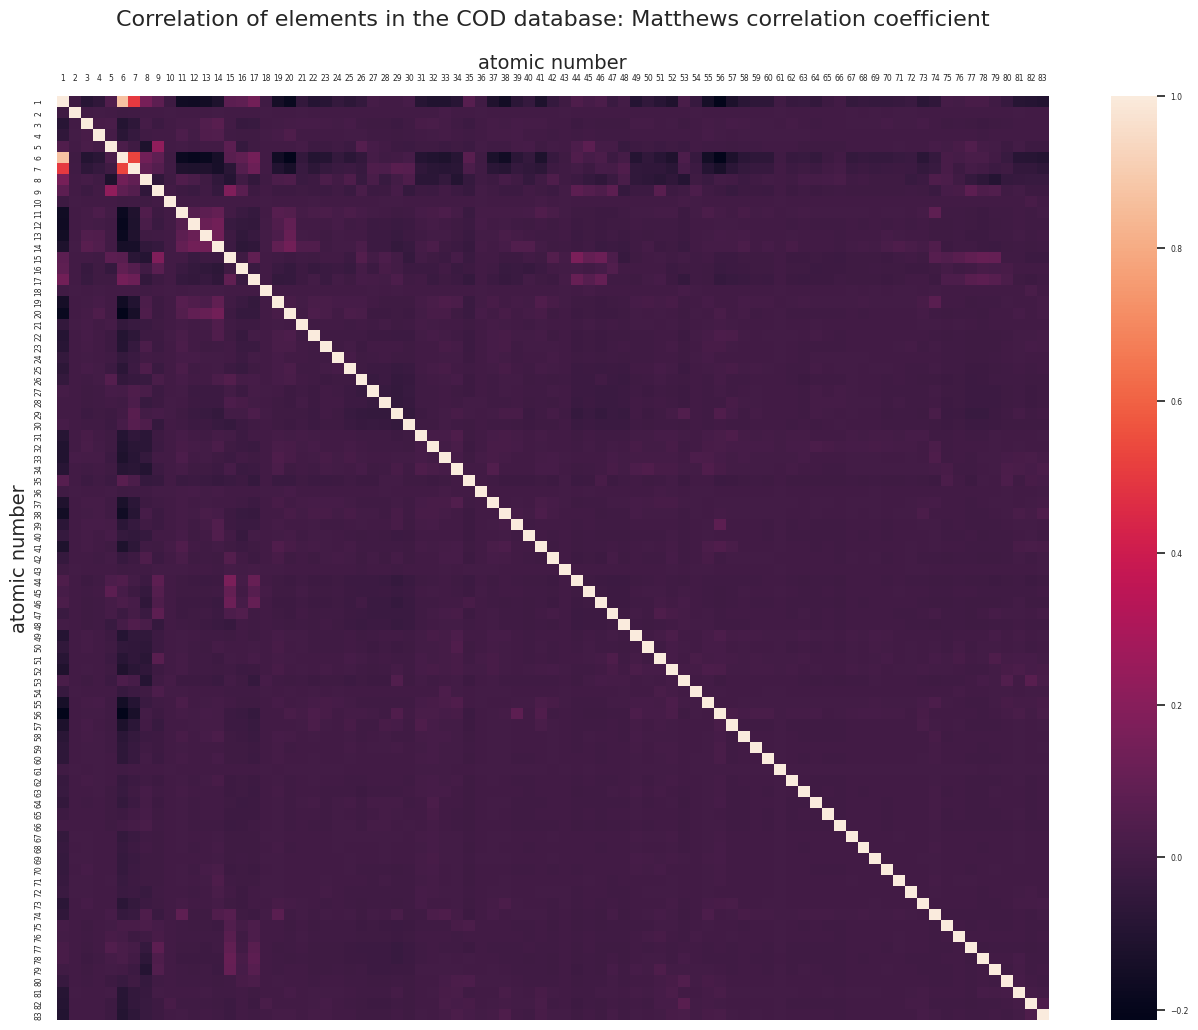

In [22]:
heatmap = plt.figure(figsize=(16, 12))
ax4 = sns.heatmap(mcc_matrix)
sns.set(font_scale=0.5)
ax4.set_ylabel('atomic number', fontsize=14)
ax4.set_xlabel('')  # Empty xlabel
ax4.xaxis.tick_top()  # x axis on top
ax4.xaxis.set_label_position('top')  # x axis label on top
ax4.set_xlabel('atomic number', fontsize=14)
ax4.set_title('Correlation of elements in the COD database: Matthews correlation coefficient', fontsize=16, pad=20)
ax4.tick_params(axis='x', which='both', bottom=False, top=False)  # remove x-axis ticks
plt.show()

## 5. Dimensionality reduction

The correlation matrix is generally quite sparse and highly concentrated in the organic (near Carbon) region, so it makes sense to use a systematic approach to pick which elements to focus on to reduce the sparsity of the input space. It would be nice, but totally implausible, to do a brute-force calculation of which elements to pick. From 84 elements, the number of possible subsets of n elements is 84 choose n, which for n=42 equals 1.6789105e+24. Best to use something more clever and less ridiculous.

## 5a. Principal component analysis and agglomerative clustering to pick the least sparse subset of elements for analysis: visualisation over 2 PCA components

Principal component analysis is a good way to reduce the dimensionality of the data, followed by agglomerative clustering to pick a subset of elements. This is easy to visualise in 2 dimensions (2 principal components), picking some arbitrary number of clusters:

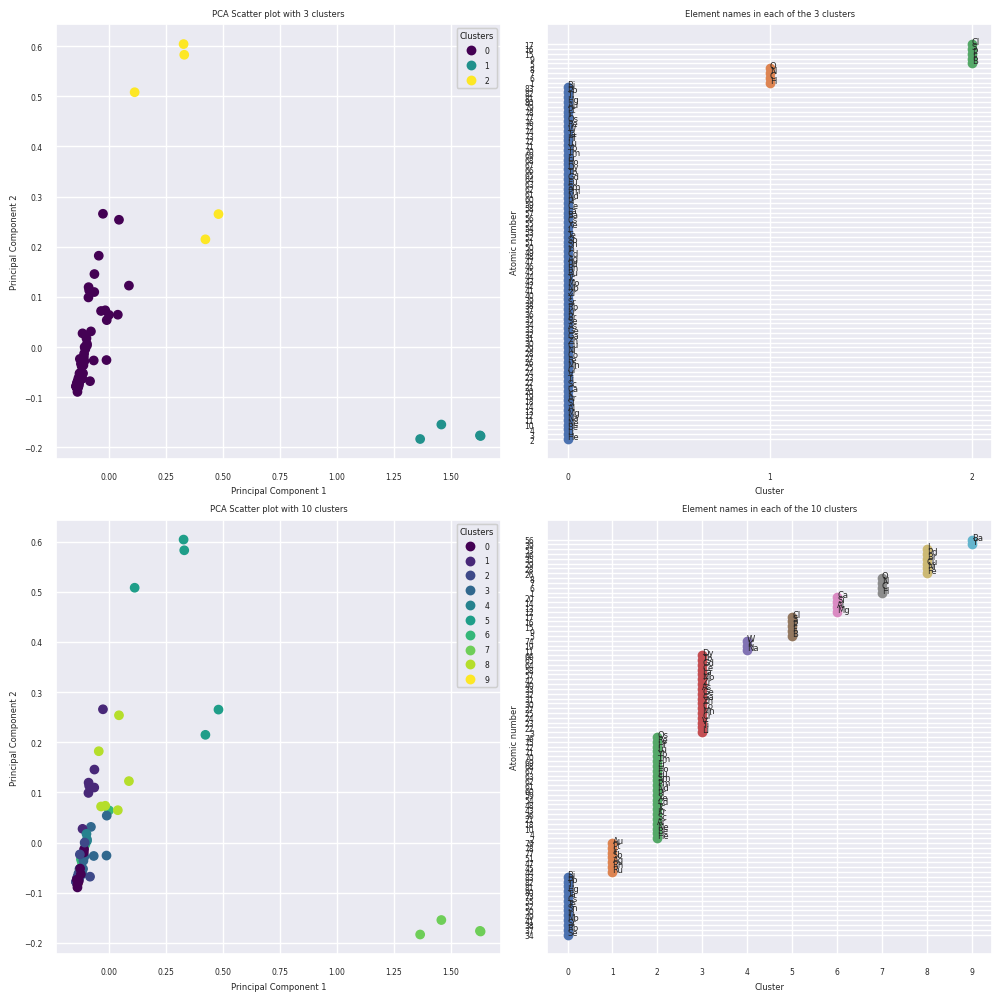

In [24]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np

n_clusters_list = [3, 10]
fig, axs = plt.subplots(len(n_clusters_list), 2, figsize=(10, 5*len(n_clusters_list)))

for i, n_clusters in enumerate(n_clusters_list):
    cluster = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    cluster_labels = cluster.fit_predict(jaccard_matrix)
    
    # Perform PCA for dimensionality reduction
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(jaccard_matrix)

    # Create a scatter plot
    scatter = axs[i, 0].scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_labels, cmap='viridis')

    # Add legend, title and labels
    legend1 = axs[i, 0].legend(*scatter.legend_elements(), title="Clusters")
    axs[i, 0].add_artist(legend1)
    axs[i, 0].set_title(f'PCA Scatter plot with {n_clusters} clusters')
    axs[i, 0].set_xlabel('Principal Component 1')
    axs[i, 0].set_ylabel('Principal Component 2')

    # For each cluster, plot the column names that are included in the cluster
    for j in range(n_clusters):
        column_names = jaccard_matrix.columns[cluster_labels == j]
        element_names = [elements[int(name)] for name in column_names]  # Get element names
        axs[i, 1].scatter(np.repeat(j, len(column_names)), column_names, label=f'Cluster {j+1}')  # Use column names for y-values
        for k, element_name in enumerate(element_names):
            axs[i, 1].text(j, column_names[k], element_name)  # Use element names for labels

    axs[i, 1].set_title(f'Element names in each of the {n_clusters} clusters')
    axs[i, 1].set_xlabel('Cluster')
    axs[i, 1].set_ylabel('Atomic number')
    axs[i, 1].set_xticks(range(n_clusters))  # Display integer labels on x-axis

plt.tight_layout()
plt.show()


It's interesting to note that the triplet C, H, and N stick together in the same cluster in all these cases. This confirms one's intuition about organic chemistry and the abundance of C in the world.

## 5b. Principal component analysis and agglomerative clustering to pick the least sparse subset of elements for analysis (systematic)

Now that some intuition has been achieved through visualisation, let's now proceed to do a more systematic grid search over the number of PCA components and clusters, and investigate the number of entries in the original dataframe that such clusters would result in. This will help to find the richest subset of input data to minimise input sparsity.

First start with a basic function to perform PCA and clustering and return a dictionary mapping each cluster index to a set of atomic numbers:

In [25]:
import multiprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from itertools import product
import ast

def cluster_jaccard_matrix(jaccard_matrix, n_clusters, n_components):
    # PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(jaccard_matrix)
    
    # hierarchical clustering on the reduced data
    cluster = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    cluster_labels = cluster.fit_predict(reduced_data)

    # dictionary mapping cluster indices to column names
    cluster_dict = {}
    for j in range(n_clusters):
        column_names = jaccard_matrix.columns[cluster_labels == j]
        cluster_dict[j] = list(column_names)
    
    return cluster_dict


def count_rows_with_elements(df, elements):
    
    # Create a mask for the columns specified
    mask_elements = df.columns.isin(elements)

    # Create a mask for the other columns
    mask_others = ~mask_elements

    # Check if *any* of the elements in the specified columns are 1 and *all* the elements in the other columns are 0
    mask_rows = (df.loc[:, mask_elements].eq(1).any(axis=1)) & (df.loc[:, mask_others].eq(0).all(axis=1))

    # Sum the number of rows that fulfill these conditions
    count = mask_rows.sum()

    return count


def process_clusters_components(args):
    n_clusters, n_components = args
    clusters_dict = cluster_jaccard_matrix(jaccard_matrix, n_clusters, n_components)
    rows = []
    for cluster_index, atomic_numbers in clusters_dict.items():
        num_cif_files = count_rows_with_elements(df, atomic_numbers)
        
        dimensions = len(atomic_numbers)
        
        row = [str(atomic_numbers), # string with atomic numbers of elements in the cluster
               dimensions,          # how many elements are in the cluster
               n_clusters,          # how many clusters were used in the agglomerative cluster algorithm
               n_components,        # how many components were used in the PCA
               num_cif_files,       # how many .cif files (i.e. rows in the original dataframe) that contain the elements referred to in atomic_numbers
               np.exp(dimensions) / num_cif_files,  # a measure of sparsity: the exponential of the number of unique elements divided by number of cif files containing those elements
        ]
        
        rows.append(row)
    return rows


n_clusters_components = list(product(range(1, 5), repeat=2))

#num_cores= multiprocessing.cpu_count()
num_cores = 8

with multiprocessing.Pool(num_cores) as p:
    results = p.map(process_clusters_components, n_clusters_components)

# Flatten the list of results and add them to the DataFrame
results = [row for sublist in results for row in sublist]

df_ = pd.DataFrame(results, columns=['atomic_numbers', 'num_elements', 'n_clusters', 'n_components', 'num_cif_files', 'sparsity'])


df_['atomic_numbers'] = df_['atomic_numbers'].apply(ast.literal_eval)
for i in range(1, 84):
    df_[str(i)] = 0

    
for index, row in df_.iterrows():
    for atomic_number in row['atomic_numbers']:
        df_.loc[index, str(atomic_number)] = 1

df_ = df_.drop('atomic_numbers', axis=1)
df_ = df_.sort_values('sparsity', ascending=True)


# drop the PCA components and number of clusters since they're just artefacts of the grid search for the dimensionality reduction#
df_ = df_.drop(['n_clusters','n_components'], axis=1)
df_.drop_duplicates(inplace=True)
df_ = df_.reset_index(drop=True)
df_.to_csv('element-masks.csv', index=False)

In [59]:
df_

,num_elements,num_cif_files,sparsity,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83
0,4,76043,7.179905e-04,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,209,2.612352e-01,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5,273,5.436379e-01,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,710,5.682096e-01,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,233,6.369663e-01,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,6,274,1.472368e+00,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,11,1263,4.740629e+01,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,14,1474,8.158781e+02,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0
8,60,6728,1.697395e+22,0,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1
9,64,8537,7.303677e+23,0,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


## 6. Generate file lists based on choices of which elements to include

By saving the dataframe df_ as a .csv file, it can be reopened in a Python module or different Jupyter notebook in order to select the input files for an ML model by selecting a row. Something like the below:

In [58]:
df_ = pd.read_csv('element-masks.csv')
df = pd.read_csv('counts-reduced.csv', index_col=[0])

element_masks = df_.loc[1, atomic_numbers]
masked_elements = row_values[element_masks == 1].index
masked_elements

result = get_cif_filenames(df, masked_elements, include_all=False, exclude_others=True)
print(result[:10])

['1538650.cif', '1537087.cif', '9014077.cif', '1536694.cif', '1538496.cif', '1008974.cif', '9013123.cif', '4113941.cif', '1536776.cif', '2310015.cif']
